In [1]:
!pip install spectral-cube
!pip install pvextractor 
!pip install --upgrade scikit-learn
!pip install plotly --upgrade

# basic python libraries
import numpy as np
import pandas as pd
# We'll use this later
from numpy import meshgrid
from scipy import stats
from scipy import optimize
from scipy.optimize import fsolve 
from scipy.constants import*
from scipy import*
import scipy.ndimage as nd
from sympy import nsolve

## For plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from matplotlib import*
import seaborn as sns
# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

# >>>>>> Astro packages >>>>>>>>>
from spectral_cube import SpectralCube
from spectral_cube import* # SpectralCube 
from spectral_cube import Projection 
import scipy.ndimage as nd
from pvextractor import extract_pv_slice
from pvextractor import Path


# astropy libraries
#from astropy.convolution import Box1DKernela
from astropy.io import fits
from astropy.convolution import Kernel1D
from astropy import constants as con
from astropy import units as u
#import matplotlib.mlab as mlab
from astropy.convolution import Kernel1D
from astropy.table import Table
from astropy.wcs import WCS
from astropy.wcs import utils 
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.table import QTable
#from yt.mods import ColorTransferFunction, write_bitmap
#from astropy import yt
import warnings
from astropy.io import fits
from astropy.table import vstack, hstack, join
from astropy import units as u
from astropy.visualization.wcsaxes import Quadrangle

#import aplpy

# Import DataSci and ML packages and classes >>>>>>>>>>>>>>>>>>
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor as gbreg 

     |████████████████████████████████| 218 kB 3.5 MB/s 
     |████████████████████████████████| 73 kB 1.1 MB/s 
     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 24.8 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


In [2]:
#############################################################################################################
## >>>>>>>>>>>>>>>>> Alternative way of uploading and reading files >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#############################################################################################################
from google.colab import drive
drive.mount('/content/gdrive')

filepath = '/content/gdrive/MyDrive/0.Work/RESEARCH_INFO/Research_2021/PilotSurvey_Newfields//Large-sample-outflows-in-CygX-and-ML-methods/'
#filepath = "C:\\Users\\Uber-PC\\Google Drive\\0.Work\\CourseworkStudyMaterial\\Data_Science\\Fall2021\\Erdos_GitHub\\fall-2021\\python prep\\Practice Problems\\" # <<<< this only works with Jupyter Notebook 
           #"C:\Users\Uber-PC\Google Drive\0.Work\CourseworkStudyMaterial\Data_Science\Fall2021\Erdos_GitHub\fall-2021\python prep\Practice Problems\random_walk.csv"


##########################################################################################################################
kryu_list = Table.read(filepath + '/data/asu (1).fit') # original Kryukova survey 
proto = Table.read(filepath + '/data/cygx_pilot_protostars(Kry).fit')
wu = Table.read(filepath + '/data/WuTable.fit')
outflowsCloud = Table.read(filepath + '/data/outflowsClouds_output.fit')


cygx_mom0 = SpectralCube.read(filepath + '/data/cygx_mom0.fits')

# read the kryukova list 
#stars_kry = Table.read('asu (1).fit') 

# read coordinates tables 
#of_newfields = Table.read(filepath + 'table_newfields_input.fit')
of_cygrift = Table.read(filepath + '/data/cygX_pilot_cygrift0.65kpc_outout.fit')
of_W75 = Table.read(filepath + '/data/cygX_pilot_W75_outout.fit')
of_DR21 = Table.read(filepath + '/data/cygX_pilot_DR21_outout.fit')

cygX_newfields = SpectralCube.read(filepath + '/data/cygx_cobig_small.fits')
#cygX_pilot = SpectralCube.read(filepath +'cygX_pilot_km.fits')
#cygX_init_newfields = QTable.read(filepath+'table_newfields_input.fit')
cygX_init_pilot_1_5kpcA =  QTable.read(filepath + '/data/cygX_pilot_1.5kpc_A_input.fit')

Mounted at /content/gdrive


In [ ]:
##############   MODIFY WU LIST HERE  #########################################

from pandas.plotting import scatter_matrix
def converter(z):
  try:
    return(np.float(z))
  except:
    return(np.nan)

wu['t'] = wu['t'].to(10*u.kyr)
wu['E'] = (wu['E']).to(1e44*u.erg)
wu['Lbol'] = np.array([converter(dummy_variable) for dummy_variable in wu['Lbol']])*u.solLum
print('NaNs in the data \n Lbol',len(wu[np.isnan(wu['Lbol'])]), '\n Mass', len(wu[np.isnan(wu['Mass'])]), '\n Energy', len(wu[np.isnan(wu['E'])]), '\n ................')

# clean data
wu_refined = (wu[~np.isnan(wu['Lbol'])]) # removes all entries with NaN Lbol values
print('NaNs in the data \n Lbol',len(wu_refined[np.isnan(wu_refined['Lbol'])]), '\n Mass', len(wu_refined[np.isnan(wu_refined['Mass'])]), '\n Energy', len(wu_refined[np.isnan(wu_refined['E'])]), '\n ................')
wu_refined = wu_refined[wu_refined['t'] > 0]
wu_refined = wu_refined[wu_refined['Mass'] > 0]
wu_refined = wu_refined[wu_refined['E'] > 0]

wu_df = (wu_refined.to_pandas())[['Mass', 'E', 't', 'Lbol']]

#  add log values
wu_df['logMass'] = np.log10(wu_df['Mass'])
wu_df['logE'] = np.log10(wu_df['E'])
wu_df['logt'] = np.log10(wu_df['t'])
wu_df['logLbol'] = np.log10(wu_df['Lbol'])

print(wu_df.head(3))
print(wu_df.describe())


logMass_range = ((wu_df['logMass'].mean() - 3.3 * np.sqrt(wu_df['logMass'].var()), wu_df['logMass'].mean() + 3.3 * np.sqrt(wu_df['logMass'].var())))
logE_range = ((wu_df['logE'].mean() - 3.3 * np.sqrt(wu_df['logE'].var()), wu_df['logE'].mean() + 3.3 * np.sqrt(wu_df['logE'].var())))
logt_range = ((wu_df['logt'].mean() - 3.3 * np.sqrt(wu_df['logt'].var()), wu_df['logt'].mean() + 3.3 * np.sqrt(wu_df['logt'].var())))
logLbol_range = ((wu_df['logLbol'].mean() - 3.3 * np.sqrt(wu_df['logLbol'].var()), wu_df['logLbol'].mean() + 3.3 * np.sqrt(wu_df['logLbol'].var())))

print('mass range = ',logMass_range, '\n energy range =', logE_range, '\n dynamical time range = ', logt_range, '\n Lbol range = ', logLbol_range)

NaNs in the data 
 Lbol 387 
 Mass 0 
 Energy 0 
 ................
NaNs in the data 
 Lbol 0 
 Mass 0 
 Energy 0 
 ................
    Mass        E     t      Lbol   logMass      logE      logt   logLbol
0  45.50  8000.00   8.0  460000.0  1.658011  3.903090  0.903090  5.662758
1   1.13     6.11  18.0      12.9  0.053078  0.786041  1.255273  1.110590
2   1.52    13.20  11.5       9.9  0.181844  1.120574  1.060698  0.995635
             Mass            E           t  ...        logE        logt     logLbol
count  239.000000   239.000000  239.000000  ...  239.000000  239.000000  239.000000
mean    20.610805   466.626067    7.311573  ...    1.084968    0.564670    2.673257
std     53.482634  1391.951695    8.889137  ...    1.590377    0.575400    1.720953
min      0.000400     0.000002    0.075000  ...   -5.602060   -1.124939   -0.744727
25%      0.300000     0.700000    1.750000  ...   -0.154902    0.242861    1.146128
50%      3.400000    14.000000    4.100000  ...    1.146128    0.612

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

-infty in log mass 0
r= 0.01 and alpha= 0.001 

lengths of test set and train set in this split= 10 38 

test index in this 1 th Kfold split: [ 2  7  9 13 25 28 36 39 42 43] 
 and train_index : [ 0  1  3  4  5  6  8 10 11 12 14 15 16 17 18 19 20 21 22 23 24 26 27 29
 30 31 32 33 34 35 37 38 40 41 44 45 46 47] 

ElasticNet MSE for 1 -th fold is 6.342146624009539 for r= 0.01 and alpha= 0.001 

lengths of test set and train set in this split= 10 38 

test index in this 1 th Kfold split: [ 0 10 11 21 22 23 29 32 37 45] 
 and train_index : [ 1  2  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 20 24 25 26 27 28 30
 31 33 34 35 36 38 39 40 41 42 43 44 46 47] 

ElasticNet MSE for 2 -th fold is 4.199247330093896 for r= 0.01 and alpha= 0.001 

lengths of test set and train set in this split= 10 38 

test index in this 1 th Kfold split: [ 3  5  6 19 31 38 40 41 46 47] 
 and train_index : [ 0  1  2  4  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25 26 27
 28 29 30 32 33 34 35 36 37 39 42 43 44

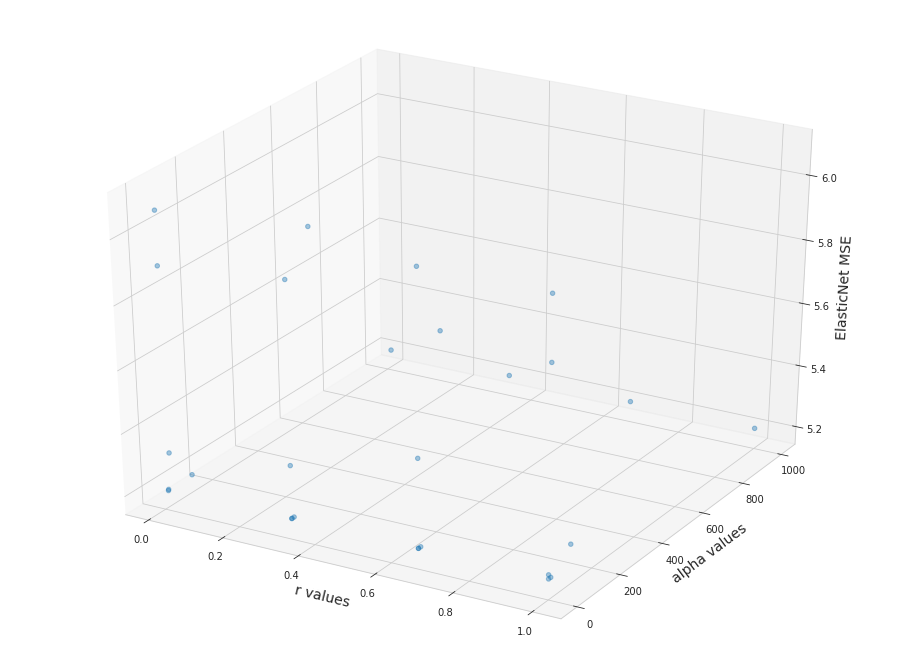

Minimum EsaticNet MSE occurs at,  [[0.01       0.01       5.20519313]] 

at r= 0.01 alpha= 0.01
models beta and intercept: [-0.42671165  0.63468632 -0.40102732] [1.49388316]


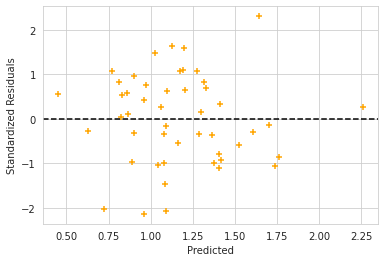

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

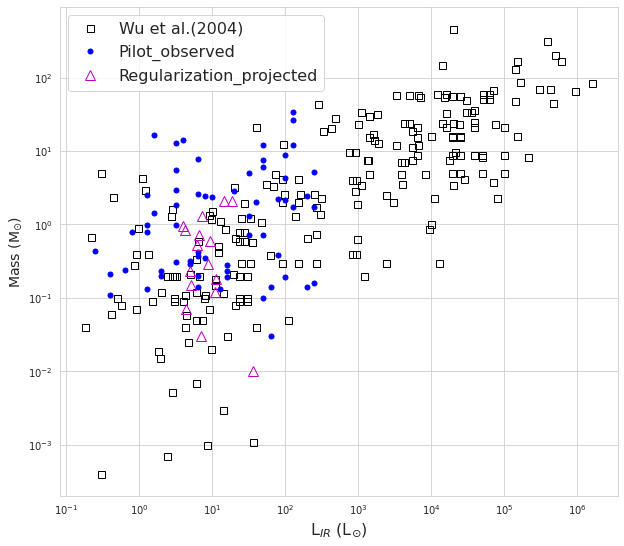

---------------------


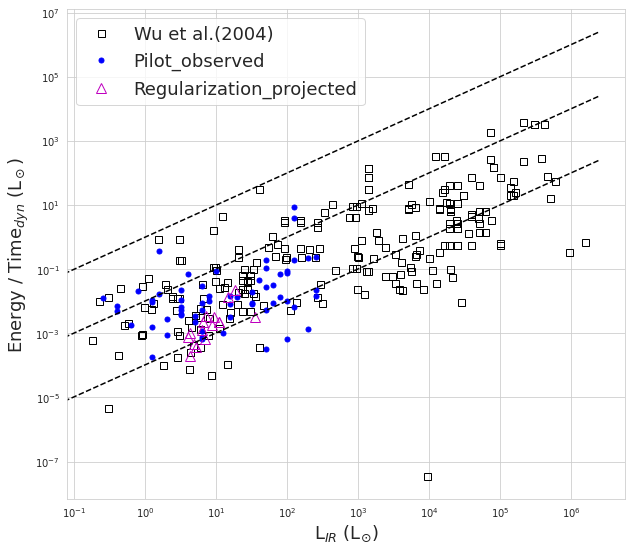

In [ ]:
## code here >>>>>>>>>>>>>> USE THE COMBINED FIELD (NEWFIELD+PILOT) OBSERVED OUTFLOWS+PROTO (66) ASSOCIATION TO PREDICT THE MISSING PROTOSTAR L_IR >>>>>>>>>>>

#####################################################################################################################################################
# >>>>>>>> K CROSS VALIDATION TO FIND THE BEST ALPHA AND R (REGULARIZATION PARAMETERS)
#####################################################################################################################################################
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor as gbreg 
## this calculates the test mse
def get_mse(model, X_train, X_test, y_train, y_test):
    # fit the model and get coeffs
    model.fit(X_train,y_train)
    print('models beta and intercept:', model.coef_, model.intercept_)

    # get the prediction
    pred = model.predict(X_test)

    # Returns the mse
    return np.sum(np.power(np.array(pred)-y_test,2))/len(pred)

#proto = Table.read('cygxPilot_proto.fits')
#wu = Table.read('WuTable.fit')
#outflowsCloud = Table.read('outflowsClouds_output.fit')



rs = np.linspace(0.01, 1, 4)
alphas = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2,1e3]
rv, alphav = np.meshgrid(rs, alphas)
r_alpha_grid = np.concatenate([rv.reshape(-1,1), alphav.reshape(-1,1)], axis=1)

MSE_regr = np.empty((len(rs),len(alphas),5))

# coefs cintains coeffs for each of 10 betas for every value of alpha 
regr_coefs = np.empty((len(rs),len(alphas),5)) 


# load data and tables >>>>>>>>>>>>

cygx_ofs_with_LIR = pd.read_csv(filepath + '/data/cygx_ofs_with_LIR.csv') 
pilotL = cygx_ofs_with_LIR # <<<<<<<< use the same same name for the sake for the code body, but the dataset is not only Pilot survey anymore

pilotL_refined = pilotL[pilotL['Dynamical Time'] > 0] # 'proto_arcmin.csv'  <<<<<<<<<<<< list observed L_IR
pilotL_refined = pilotL_refined[pilotL_refined['Mass'] > 0]
pilotL_refined = pilotL_refined[pilotL_refined['Energy'] > 0] 
pilotL_refined = pilotL_refined[pilotL_refined['logL_proto'] > 0]

pilotL_df = pilotL_refined[['Mass', 'Energy', 'Dynamical Time', 'logL_proto']]

#add log values
pilotL_df['logMass'] = np.log10(pilotL_df['Mass'])
pilotL_df['logE'] = np.log10(pilotL_df['Energy'])
pilotL_df['logt'] = np.log10(pilotL_df['Dynamical Time'])
#$pilotL_df['logL_proto'] = np.log10(pilotL_df['logL_proto'])
#pilotL_df['logLbol_proj.'] =  2.238  + ( 1.015 ) * clouds_df['logMass'] + ( 0.248 ) * clouds_df['logE'] + ( -0.293 ) * clouds_df['logt']


print('-infty in log mass',len(pilotL_df[(pilotL_df['logMass']) == -inf]))

# model and target defined 
variables = ['logMass', 'logE', 'logt', 'logL_proto']
features = ['logMass', 'logE', 'logt']
target = [ 'logL_proto']

# train test spllit
pilotL_train, pilotL_test =  train_test_split(pilotL_df[variables].copy(), test_size=0.15, random_state= 614)

## make a kfold object
kfold = KFold(n_splits=5, shuffle=True, random_state=789)

for i in range(len(rs)):
  for j in range(len(alphas)):
    print('r=', rs[i], 'and alpha=',alphas[j],'\n')

    # create cross validation folds
    k = 0
    for train_index, test_index in kfold.split(pilotL_train):
      print('lengths of test set and train set in this split=', len(test_index), len(train_index), '\n')
      print('test index in this', i+1, 'th Kfold split:', test_index, '\n and train_index :', train_index, '\n')
      pilotL_train_train = pilotL_train.iloc[train_index]
      pilotL_train_test = pilotL_train.iloc[test_index]
      #ads_holdout = ads_train.iloc[test_index]

      # build model 
      regr = ElasticNet(alpha=alphas[j],l1_ratio=rs[i],fit_intercept=True,copy_X=True, max_iter=5000000)
  
      # fit with pipeline 
      #pipe_regr = Pipeline([('transform',pipe_polyscaler),('elasticNet', regr)])

      regr.fit(pilotL_train_train[features], pilotL_train_train[target]) # reshaping because the transformation pipeline will make it a 10 dimensional axes data 
      #regr_coefs[i,j,:] = np.round(regr.coef_,3)


      ## add the predictions to the grid array
      clone_regr = clone(regr)
      clone_regr.fit(pilotL_train_train[features], pilotL_train_train[target])

      MSE_regr[i,j,k] = np.sum((clone_regr.predict(pilotL_train_test[features]) - (pilotL_train_test[target]).values )**2) / len(pilotL_train_test[target].values)
      print('ElasticNet MSE for', k+1, '-th fold is', MSE_regr[i,j,k], 'for r=', rs[i], 'and alpha=',alphas[j],'\n')
      k += 1

    #print('ElasticNet MSE =', MSE_regr[i,j],'for r=', rs[i], 'and alpha=',alphas[j])




print(MSE_regr.mean(axis=2))

print(MSE_regr.shape),
print(rs)
print('\n', alphas)
MSE_regr.mean(axis=2)

r_alpha_grid = np.concatenate([r_alpha_grid, MSE_regr.mean(axis=2).reshape(-1,1)], axis=1)


from matplotlib import cm
fig = plt.figure(figsize=(16,12))
## We'll add a 3d subplot object
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_alpha_grid[:, 0], r_alpha_grid[:, 1], r_alpha_grid[:,2], cmap=cm.hot, alpha=0.4)

## Add labels
ax.set_xlabel("r values", fontsize=14)
ax.set_ylabel("alpha values", fontsize=14)
ax.set_zlabel("ElasticNet MSE", fontsize=14)

#plt.legend(fontsize=14)
plt.show()


#####################################################################################################################################################
# >>>>>>>>>>>>>>>>>>>>>>>>>   RESIDUAL PLOT FOR VERIFYING QUALITY OF FIT 
#####################################################################################################################################################

print('Minimum EsaticNet MSE occurs at, ',r_alpha_grid[r_alpha_grid[:,2] == r_alpha_grid[:,2].min()], '\n')
r_alphs_grid_min = r_alpha_grid[r_alpha_grid[:,2] == r_alpha_grid[:,2].min()]
print('at r=', r_alphs_grid_min[0][0],'alpha=',r_alphs_grid_min[0][1])


regr = ElasticNet(alpha=r_alphs_grid_min[0][1],l1_ratio=r_alphs_grid_min[0][0],fit_intercept=True,copy_X=True, max_iter=5000000)
  
regr.fit(pilotL_train[features], pilotL_train[target]) # reshaping because the transformation pipeline will make it a 10 dimensional axes data 
#regr_coefs[i,j,:] = np.round(regr.coef_,3)

## add the predictions to the grid array
#clone_regr = clone(regr)
#clone_regr.fit(pilotL_train_train[features], pilotL_train_train[target])

#MSE_regr[i,j,k] = np.sum((clone_regr.predict(pilotL_train_test[features]) - (pilotL_train_test[target]).values )**2) / len(pilotL_train_test[target].values)
#print('ElasticNet MSE for', k+1, '-th fold is', MSE_regr[i,j,k], 'for r=', rs[i], 'and alpha=',alphas[j],'\n')

X_train = np.array(pilotL_train[features])
X_test = np.array(pilotL_test[features])

y_train = np.array(pilotL_train[target])
y_test = np.array(pilotL_test[target])
#y_valid =  np.array(pilotL_test[target])

get_mse(regr, X_train, X_test, y_train, y_test)
pred = regr.predict(X_train)

import scipy.stats as stats
res = pred - y_train.flatten()
plt.scatter(pred, stats.zscore(res),marker='+', color='b')
#plt.plot(pred, stats.zscore(res),marker='.')
plt.axhline(y=0, linestyle='--', color='k')
plt.xlabel('Predicted')
plt.ylabel('Standardized Residuals')
plt.savefig(filepath + '/output/Residual_ElasticNet_LIR_fit.pdf', overwrite=True)
plt.show()
plt.close()
#####################################################################################################################################################
# >>>>>   ElasticNet Projection of L_IR for outflowsCloud data Newfields data along with Pilot survey observations and Wu observations 
#####################################################################################################################################################

cygx_ofs_without_LIR  = pd.read_csv(filepath + '/data/cygx_ofs_without_LIR.csv') # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< list of missing L_IR
#<< keeping the name for the sake of code body


clouds = cygx_ofs_without_LIR  # <<<< ENtire list 
clouds_refined = clouds[clouds['Dynamical Time'] > 0]
clouds_refined = clouds[clouds['Mass'] > 0]
clouds_refined = clouds[clouds['Energy'] > 0]

clouds_df = clouds_refined[['ID',	'RAJ2000',	'DecJ2000', 'Mass', 'Momentum','Energy','Dynamical Time']]

#add log values
clouds_df['logMass'] = np.log10(clouds_df['Mass'])
clouds_df['logE'] = np.log10(clouds_df['Energy'])
clouds_df['logt'] = np.log10(clouds_df['Dynamical Time'])

features = ['logMass', 'logE', 'logt']
clouds_df['logLbol_proj.'] =  regr.predict(clouds_df[features]) # <<<<<<<<< regr is an ElasticNet Model



# >>>>>>>>>>>>>>>>>>>>>>>>>>>  COMPARISON PLOT >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


plt.figure(figsize=(10,9))
plt.loglog(10**(wu_df['logLbol']), 10**(wu_df['logMass']), 'ks',  markersize=7, markerfacecolor='none', markeredgecolor='black', label='Wu et al.(2004)')
plt.loglog(10**(pilotL['logL_proto']), (pilotL['Mass']), 'b.', markersize=10, markerfacecolor='blue', markeredgecolor='blue', label='Pilot_observed')
plt.loglog(10**(clouds_df['logLbol_proj.']), 10**(clouds_df['logMass']), '^', markersize=10, markerfacecolor='none', markeredgecolor='m', label='Regularization_projected')
plt.xlabel('L$_{IR}$ (L$_{\odot}$)', fontsize = 16)
plt.ylabel('Mass (M$_{\odot}$)', fontsize = 14)
plt.legend(fontsize=16)
plt.savefig(filepath + '/output/Mass+LIR_projected(ElasticNet_66_84).pdf', format='pdf', dpi=300, overwrite=True)
plt.show()
plt.close()

print('---------------------')
m = wu_df['logLbol'].max()
x = np.linspace(0, 10**max(wu_df['logLbol']+0.2))
y1 = x
y2 = 1e-2*x
y3 = 1e-4 * x
#clouds_df_newfields = clouds_df.copy().loc[46:]

plt.figure(figsize=(10,9))
plt.loglog(10**(wu_df['logLbol']), (10**(wu_df['logE']) / 10**(wu_df['logt'])) * ((1e44*u.erg / (10*u.kyr)).to(u.solLum)), 's',  markersize=7, markerfacecolor='none', markeredgecolor='black', label='Wu et al.(2004)')
plt.loglog(10**(pilotL['logL_proto']), ((pilotL['Energy'] / pilotL['Dynamical Time'] ) * ((1e44*u.erg / (10*u.kyr)).to(u.solLum))), '.', markersize=10, markerfacecolor='blue', markeredgecolor='blue', label='Pilot_observed')
plt.loglog(10**(clouds_df['logLbol_proj.']), (10**(clouds_df['logE']) / 10**(clouds_df['logt'])) * ((1e44*u.erg / (10*u.kyr)).to(u.solLum)), '^', markersize=10, markerfacecolor='none', markeredgecolor='m', label='Regularization_projected')
#plt.loglog(10**(clouds_df_newfields['logLbol_proj_gradBoost']), (10**(clouds_df_newfields['logE']) / 10**(clouds_df_newfields['logt'])) * ((1e44*u.erg / (10*u.kyr)).to(u.solLum)), 'r+', markersize=10, markerfacecolor='none', markeredgecolor='m', label='GradBoost_projected')
# Plot 3 lines here 
plt.loglog(x,y1,'k--')
plt.loglog(x,y2,'k--')
plt.loglog(x,y3,'k--')
plt.xlabel('L$_{IR}$ (L$_{\odot}$)', fontsize = 18)
plt.ylabel('Energy / Time$_{dyn}$ (L$_\odot$)', fontsize = 18)
plt.legend(fontsize=18)
#plt.savefig('Energy_dissipated+LIR_projected(GradBoost with Pilot observations).pdf', format='pdf', dpi=300, overwrite=True)
plt.savefig(filepath + '/output/Energy_dissipated+LIR_projected(ElasticNet_66_84).pdf', format='pdf', dpi=300, overwrite=True)
plt.show()
plt.close()

In [ ]:
############################################################################################################################################
################                                                                ############################################################          
# >>>>>>>>>>>>>>   MODEL FOR OUTFLOW NUMBERS, CLASS 0, CLASS 1 PROTOSTARS       >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>>>>>>>>>>>>             PROJECTION BASED ON 12CO AND 21CM                  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
################                                                                ############################################################
############################################################################################################################################

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


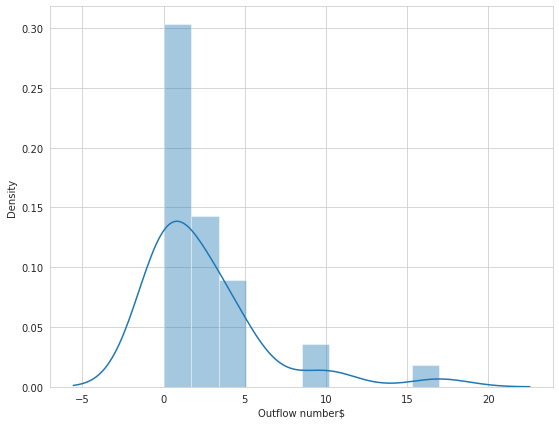

In [46]:
plt.figure(figsize=(9,7))
sns.distplot(outflows_df['outflow_number'], kde=True, axlabel='Outflow number$')
plt.show()
plt.close()

In [2]:
outflows_df_all = pd.read_csv(filepath + '/data/co+21cm49.csv').drop('Unnamed: 0', axis=1).drop([0, 1,5,6,7,8,12,13,20,21,28,34,35,40,41,42,47,48])

NameError: ignored

In [92]:
outflows_df_all.dropna().sort_values('outflow_number').mean() #.hist()

12CO(K km/s)                3.634943
21cm(K)                    15.206788
outflow_number              2.766667
class0_protostar_number     4.433333
class1_protostar_number    35.933333
dtype: float64

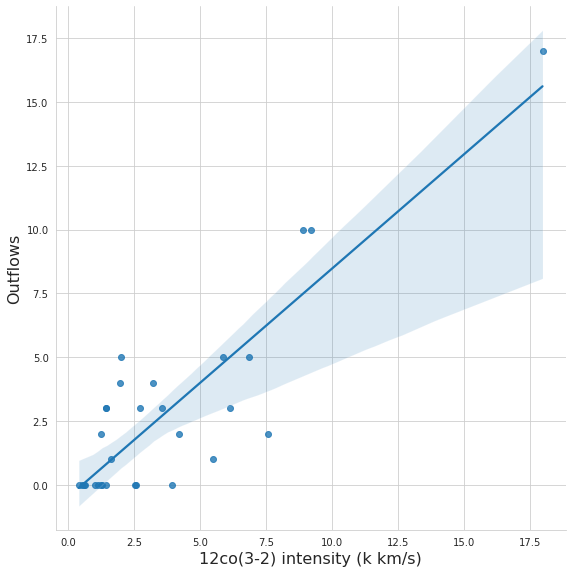

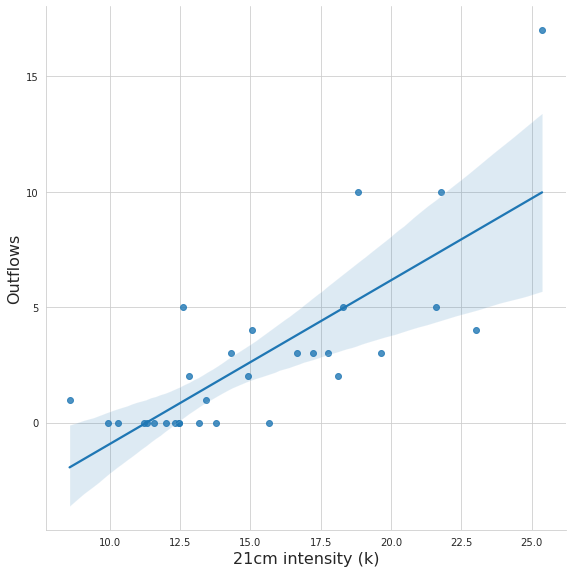

In [100]:
#>>>>>>> OUTFLOW NUMBERS PROJECTION 

#outflows_df = pd.read_csv(filepath + '/data/co+21cm49.csv').drop('Unnamed: 0', axis=1)
#outflows_df = outflows_df.copy().rename(columns={"12co(k km/s)": '12CO(K km/s)', "21cm (k)": '21cm(K)'})

co_avg = outflows_df['12CO(K km/s)'].mean()
outflows_df = outflows_df.fillna(co_avg)
outflow_df = outflows_df.copy()
# >>>>>>>>>   replace all zero outflow rows with a single row
val_co = (outflows_df.loc[outflows_df['outflow_number']==0])['12CO(K km/s)'].mean()
val_21cm = (outflows_df.loc[outflows_df['outflow_number']==0])['21cm(K)'].mean()
#outflows_df = outflows_df[outflows_df['outflow_number'] != 0]
outflows_df.drop(outflows_df.loc[outflows_df['outflow_number']==0].index, inplace=True)
new_row = {'outflow_number': 0, 'class0_protostar_number':0, 'class1_protostar_number':0, '12CO(K km/s)': val_co, '21cm(K)': val_21cm}
d = pd.Series(new_row)
data = pd.DataFrame(d)
outflows_df = outflows_df.append(d, ignore_index=True)
outflows_df = outflows_df.sort_values(by=['outflow_number'])

# >>  standardizing data 
outflows_df['12CO_zscore(K km/s)'] = stats.zscore(outflows_df['12CO(K km/s)'])
outflows_df['21cm_zscore(K)'] =  stats.zscore(outflows_df['21cm(K)'])

outflow_df['12CO_zscore(K km/s)'] = stats.zscore(outflow_df['12CO(K km/s)'])
outflow_df['21cm_zscore(K)'] =  stats.zscore(outflow_df['21cm(K)'])

## >>>>>>>>>  Display cleaned data >>>>>>>>>>>>>

outflows_df = outflows_df_all.dropna()
sns.lmplot(data=outflow_df, x='12CO(K km/s)', y='outflow_number', hue=None, height=8, ci=95)

plt.xlabel("12co(3-2) intensity (k km/s)", fontsize = 16)
plt.ylabel("Outflows", fontsize = 16)
plt.savefig(filepath + '/output/12co_outflows.pdf')
plt.show()
plt.close()


sns.lmplot(data=outflow_df, x='21cm(K)', y='outflow_number', hue=None, height=8, ci=95)
plt.xlabel("21cm intensity (k)", fontsize = 16)
plt.ylabel("Outflows", fontsize = 16)
plt.savefig(filepath + '/output/21cm_outflows.pdf')
plt.show()
plt.close()

In [125]:
pr.fit(np.array(X).reshape(-1,1),  np.array(y).flatten())
np.array(X).flatten()

array([14.92785168, 12.60480118, 10.2796917 , 19.64862633, 15.06107044,
       12.33699703, 23.00341415, 15.65573692, 13.18206596, 12.46931267,
       11.31825829, 17.21401787, 18.29520798, 13.78249741, 14.31429005,
       16.66831398,  8.57534122, 17.74830437, 21.59407043, 21.75632477,
       13.41550636, 12.47848415, 12.00751495, 18.82435226, 25.36442757,
       11.57116795,  9.94319248, 11.23364735, 18.10036659, 12.8287859 ])

In [1]:
#>> OUTFLOW NUMBER BASED ON 12CO AND 21CM DATA 
import scipy.stats as stats
from sklearn.linear_model import PoissonRegressor
features = ['12CO(K km/s)',	'21cm(K)']
target = ['outflow_number']
##############################################################
outflows_df = outflows_df_all.dropna()
print('FITTING 12CO vs OUTFLOWS \n')
X = outflow_df[['12CO(K km/s)']]
y = outflow_df[target]
pr = PoissonRegressor() # instantiating the regressor class 
pr.fit(np.array(X).flatten().reshape(-1,1),  np.array(y).flatten())

y_pred = pr.predict(np.array(X).flatten().reshape(-1,1))
res = y_pred - np.array(y).flatten()

#perform Chi-Square Goodness of Fit Test
print('Goodness of fit for CO vs outflows','\n',stats.chisquare(np.array(y).flatten(), y_pred))
plt.scatter(y_pred, res.reshape(-1,1))
plt.axhline(y=0, linestyle='--', color='k')
plt.show()
plt.close()

x = np.linspace(outflow_df[['12CO(K km/s)']].min(), outflow_df[['12CO(K km/s)']].max(), 10000)
y_pred_curve = pr.predict(x)
sns.lmplot(data=outflow_df, x='12CO(K km/s)', y='outflow_number', hue=None, height=8, ci=95)
plt.scatter(X,y_pred,color='m',marker='+', label='fitted')
plt.plot( x, y_pred_curve, color='g', alpha=0.25)
plt.xlabel("12CO(K km/s)", fontsize = 16)
plt.ylabel("Outflow Number", fontsize = 16)
plt.savefig(filepath + '/output/12co_outflows_pred.pdf')
plt.show()
plt.close()


################################################
print('FITTING 21cm vs OUTFLOWS \n')
X = outflow_df[['21cm(K)']]
y = outflow_df[target]
pr = PoissonRegressor() # instantiating the regressor class 
pr.fit( np.array(X).flatten().reshape(-1,1),  np.array(y).flatten())

y_pred = pr.predict(np.array(X).flatten().reshape(-1,1))
res = y_pred - np.array(y).flatten()

#perform Chi-Square Goodness of Fit Test
print('Goodness of fit for 21cm vs outflows','\n',stats.chisquare(np.array(y).flatten(), y_pred))
plt.scatter(y_pred, res.reshape(-1,1))
plt.axhline(y=0, linestyle='--', color='k')
plt.show()
plt.close()


x = np.linspace(outflow_df[['21cm(K)']].min(), outflow_df[['21cm(K)']].max(), 10000)
y_pred_curve = pr.predict(x)
sns.lmplot(data=outflow_df, x='21cm(K)', y='outflow_number', hue=None, height=8, ci=95)
plt.scatter(X,y_pred,color='m',marker='+',label='fitted')
#plt.plot( x, y_pred_curve, color='g', alpha=0.25)
plt.xlabel("21cm(K)", fontsize = 16)
plt.ylabel("Outflow Number", fontsize = 16)
plt.savefig(filepath + '/output/21cm_outflows_pred.pdf')
plt.show()
plt.close()

NameError: ignored

Goodness of fit for CO vs class 0 proto 
 Power_divergenceResult(statistic=137.94202189149863, pvalue=3.9589541724616396e-16)


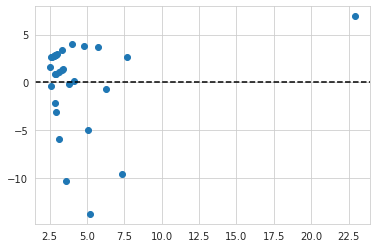

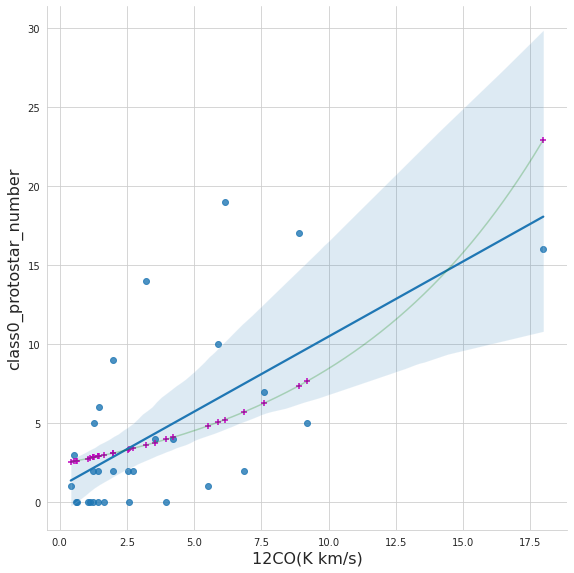

Goodness of fit for 21cm vs class 0 proto 
 Power_divergenceResult(statistic=94.34176447695651, pvalue=7.704228175698566e-09)


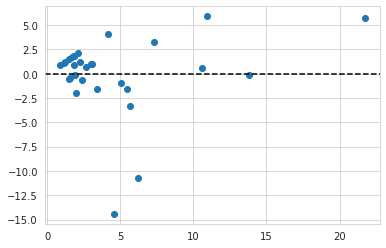

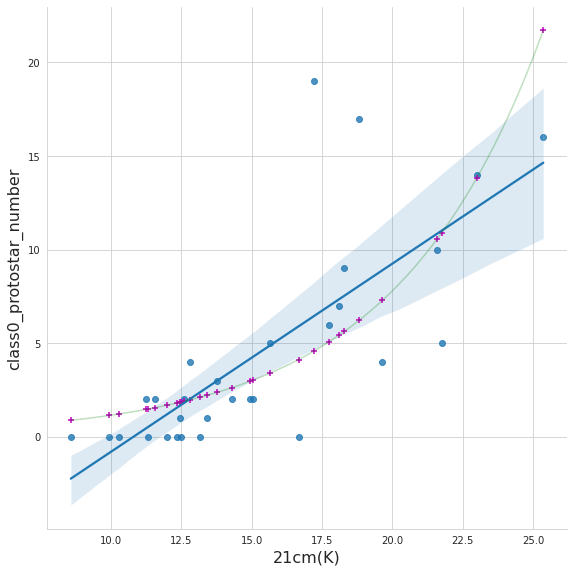

In [137]:
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  Class 0 NUMBER BASED ON 12CO AND 21CM DATA >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

from sklearn.linear_model import PoissonRegressor
features = ['12CO(K km/s)',	'21cm(K)']
target = ['class0_protostar_number']
####################################################
X = outflow_df[['12CO(K km/s)']]
#X = outflow_df[features]
y = outflow_df[target]
pr = PoissonRegressor() # instantiating the regressor class 
pr.fit(np.array(X).flatten().reshape(-1,1),  np.array(y).flatten())

y_pred = pr.predict(np.array(X).flatten().reshape(-1,1))
res = y_pred - np.array(y).flatten()
#perform Chi-Square Goodness of Fit Test
print('Goodness of fit for CO vs class 0 proto','\n',stats.chisquare(np.array(y).flatten(), y_pred))
plt.scatter(y_pred, res.reshape(-1,1))
plt.axhline(y=0, linestyle='--', color='k')
plt.show()
plt.close()


x = np.linspace(outflow_df[['12CO(K km/s)']].min(), outflow_df[['12CO(K km/s)']].max(), 10000)
y_pred_curve = pr.predict(x)
sns.lmplot(data=outflow_df, x='12CO(K km/s)', y='class0_protostar_number', hue=None,height=8, ci=95)
plt.plot( x, y_pred_curve, color='g', alpha=0.25)
plt.scatter(X,y_pred,color='m',marker='+',label='fitted')
plt.xlabel("12CO(K km/s)", fontsize = 16)
plt.ylabel("class0_protostar_number", fontsize = 16)
plt.show()
plt.close()

############################################################################################
X = outflow_df[['21cm(K)']]
#X = outflow_df[features]
y = outflow_df[target]
pr = PoissonRegressor() # instantiating the regressor class 
pr.fit(np.array(X).flatten().reshape(-1,1),  np.array(y).flatten())

y_pred = pr.predict(np.array(X).flatten().reshape(-1,1))
res = y_pred - np.array(y).flatten()
#perform Chi-Square Goodness of Fit Test
print('Goodness of fit for 21cm vs class 0 proto','\n',stats.chisquare(np.array(y).flatten(), y_pred))
plt.scatter(y_pred, res.reshape(-1,1))
plt.axhline(y=0, linestyle='--', color='k')
plt.show()
plt.close()


x = np.linspace(outflow_df[['21cm(K)']].min(), outflow_df[['21cm(K)']].max(), 10000)
y_pred_curve = pr.predict(x)
sns.lmplot(data=outflow_df, x='21cm(K)', y='class0_protostar_number', hue=None, height=8, ci=95)
plt.plot( x, y_pred_curve, color='g', alpha=0.25)
plt.scatter(X,y_pred,color='m',marker='+',label='fitted')
plt.xlabel("21cm(K)", fontsize = 16)
plt.ylabel("class0_protostar_number", fontsize = 16)
plt.show()
plt.close()

Goodness of fit for CO vs class 1 proto 
 Power_divergenceResult(statistic=777.6140415152639, pvalue=5.708278798978813e-145)


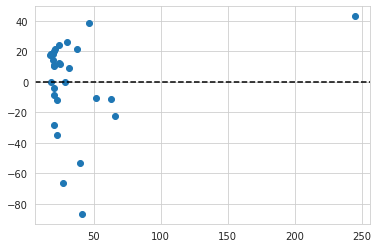

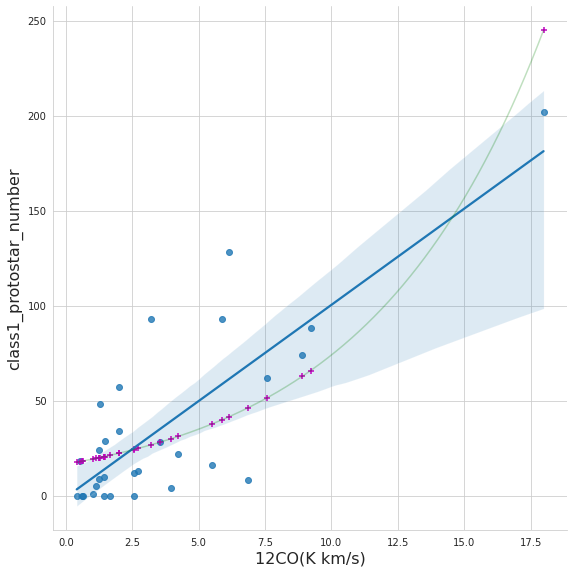

Goodness of fit for 21cm vs class 1 proto 
 Power_divergenceResult(statistic=439.26370314693315, pvalue=7.797076621762529e-75)


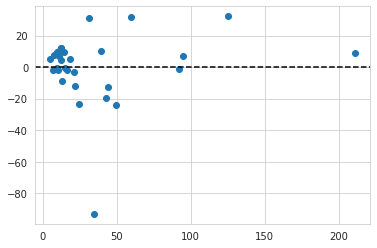

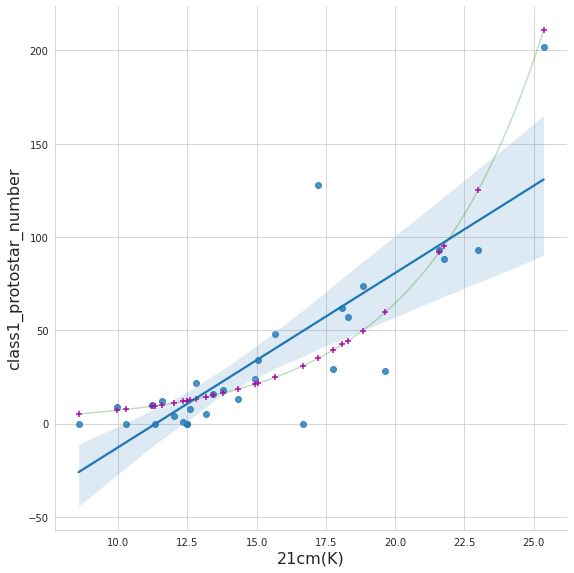

In [138]:
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  #>> Class 1 NUMBER BASED ON 12CO AND 21CM DATA  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

from sklearn.linear_model import PoissonRegressor
features = ['12CO(K km/s)',	'21cm(K)']
target = ['class1_protostar_number']
####################################################
X = outflow_df[['12CO(K km/s)']]
#X = outflow_df[features]
y = outflow_df[target]
pr = PoissonRegressor() # instantiating the regressor class 
pr.fit(np.array(X).flatten().reshape(-1,1),  np.array(y).flatten())

y_pred = pr.predict(np.array(X).flatten().reshape(-1,1))
res = y_pred - np.array(y).flatten()
#perform Chi-Square Goodness of Fit Test
print('Goodness of fit for CO vs class 1 proto','\n',stats.chisquare(np.array(y).flatten(), y_pred))
plt.scatter(y_pred, res.reshape(-1,1))
plt.axhline(y=0, linestyle='--', color='k')
plt.show()
plt.close()


x = np.linspace(outflow_df[['12CO(K km/s)']].min(), outflow_df[['12CO(K km/s)']].max(), 10000)
y_pred_curve = pr.predict(x)
sns.lmplot(data=outflow_df, x='12CO(K km/s)', y='class1_protostar_number', hue=None,height=8, ci=95)
plt.plot( x, y_pred_curve, color='g', alpha=0.25)
plt.scatter(X,y_pred,color='m',marker='+',label='fitted')
plt.xlabel("12CO(K km/s)", fontsize = 16)
plt.ylabel("class1_protostar_number", fontsize = 16)
plt.show()
plt.close()

############################################################################################
X = outflow_df[['21cm(K)']]
#X = outflow_df[features]
y = outflow_df[target]
pr = PoissonRegressor() # instantiating the regressor class 
pr.fit(np.array(X).flatten().reshape(-1,1),  np.array(y).flatten())

y_pred = pr.predict(np.array(X).flatten().reshape(-1,1))
res = y_pred - np.array(y).flatten()
#perform Chi-Square Goodness of Fit Test
print('Goodness of fit for 21cm vs class 1 proto','\n',stats.chisquare(np.array(y).flatten(), y_pred))
plt.scatter(y_pred, res.reshape(-1,1))
plt.axhline(y=0, linestyle='--', color='k')
plt.show()
plt.close()


x = np.linspace(outflow_df[['21cm(K)']].min(), outflow_df[['21cm(K)']].max(), 10000)
y_pred_curve = pr.predict(x)
sns.lmplot(data=outflow_df, x='21cm(K)', y='class1_protostar_number', hue=None, height=8, ci=95)
plt.plot( x, y_pred_curve, color='g', alpha=0.25)
plt.scatter(X,y_pred,color='m',marker='+',label='fitted')
plt.xlabel("21cm(K)", fontsize = 16)
plt.ylabel("class1_protostar_number", fontsize = 16)
plt.show()
plt.close()

In [194]:
# Import dependencies
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure the trace.
trace = go.Scatter3d(
    x=[1, 2, 3],  # <-- Put your data instead
    y=[4, 5, 6],  # <-- Put your data instead
    z=[7, 8, 9],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)
plot_figure.show()
# Render the plot.
#plotly.offline.iplot(plot_figure)

Output hidden; open in https://colab.research.google.com to view.

Goodness of fit for CO vs class 1 proto 
 Power_divergenceResult(statistic=39.66688516112162, pvalue=0.08953254461249929)


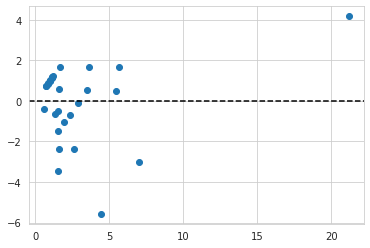

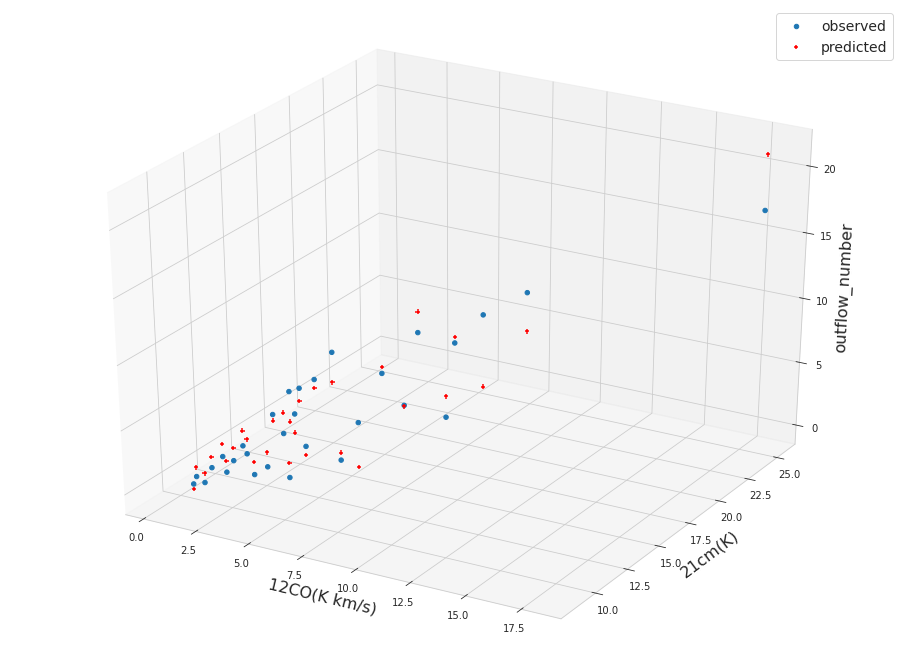

In [201]:
from sklearn.linear_model import PoissonRegressor

features = ['12CO(K km/s)',	'21cm(K)']
target = ['outflow_number']
############################################################3
X = outflow_df[features]
#X = outflow_df[features]
y = outflow_df[target]
pr = PoissonRegressor() # instantiating the regressor class 

pr.fit(X,  np.array(y).flatten())

y_pred = pr.predict(X)
res = y_pred - np.array(y).flatten()
#perform Chi-Square Goodness of Fit Test
print('Goodness of fit for CO vs class 1 proto','\n',stats.chisquare(np.array(y).flatten(), y_pred))
plt.scatter(y_pred, res.reshape(-1,1))
plt.axhline(y=0, linestyle='--', color='k')
plt.show()
plt.close()

x1 = np.array(outflow_df[features[0]])
x2 = np.array(outflow_df[features[1]])

#####################################################################
from matplotlib import cm
X1 = np.array(outflow_df[features[0]])
X2 = np.array(outflow_df[features[1]])
y = np.array(outflow_df[target])

fig = plt.figure(figsize=(16,12))
## We'll add a 3d subplot object
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, y, cmap=cm.hot, alpha=1, label='observed')
ax.scatter(X1, X2, y_pred, color='r', marker='+',alpha=1, label='predicted')
## Add labels
ax.set_xlabel("12CO(K km/s)", fontsize=16)
ax.set_ylabel("21cm(K)", fontsize=16)
ax.set_zlabel("outflow_number", fontsize=16)

plt.legend(fontsize=14)
plt.savefig(filepath + '/output/co_21cm_of.pdf')
plt.show()
plt.close()

In [ ]:
######### >>>>>>>>>>>  21cm. 12co, class 0 protostars count correlation >>>>>>>>>>>>

## Quick plot
## sns.lmplot here

#outflow_df = pd.read_csv('co+21cm.csv')
#outflow_df = pd.read_csv('co+21cm49.csv')
#outflows_df = outflow_df[~np.isnan(outflow_df['12co(k km/s)'])] 

# Code here -------------->>>>>>>>>>>---------->>>>>>>>>>>>>
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.linear_model import LinearRegression

#######################################    DEFINE FUNCTIONS   ##################
# This returns the power set of a set minus the empty set
def powerset_no_empty(s):
    power_set = []
    x = len(s)
    for i in range(1 << x): # this is a range from 0 to 2^n so all cases in a powerset 
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
            
    return power_set[1:]

## This gets our data for us
def get_X_y(df,features,target):
    # Returns X then y
    return np.array(df[features]), np.array(df[target])

## this calculates the mse
def get_mse(model, X, y):
    # fit the model and get coeffs
    model.fit(X,y)
    print('models beta and intercept:', model.coef_, model.intercept_)

    # get the prediction
    pred = model.predict(X)

    # Returns the mse
    return np.sum(np.power(pred-y,2))/len(y)

# MODEL SELECTION USING Kfold CROSS VALIDATION >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#   SELECT DATA  
variables = ['outflow_number', '12CO_zscore(K km/s)',	'21cm_zscore(K)']
features = ['12CO_zscore(K km/s)',	'21cm_zscore(K)']
target = [ 'class0_protostar_number']
outflow_train = outflow_df.copy() #.sample(frac = 0.99, random_state = 614)


# possible_features creates a set of all combinations (nC1 + nC2 + nC3 +...+ nCn) of existing n features in the original dataset 
possible_features = powerset_no_empty(features)

###############    BUILD THE MODEL   K##########################################
## Now we make a kfold object w/ 5 splits and shuffle the data before making the splits
kfold = KFold(n_splits = 5, shuffle = True, random_state = 440)

## Now make an array that will hold the mses
## for all the models
## the ROWs represent each possible model

MSEs = np.empty((len(possible_features),5))

## Make a regression model
reg = LinearRegression(copy_X = True)

################ DO THE REGRESSION in kfolds AND CALCULATE ERRORS ########################
for j in range(len(possible_features)): # possible_features contains the powerset of features, range = len=2^number of features = 127 cases
        ## get X and y
        X, y = get_X_y(outflow_train, possible_features[j], target) # this returns X matrix and y vector after removing all features right away before train-test split except for the ones needed for this specific model,  
        print('features', possible_features[j], 'X matrix shape:', X.shape) # but keeps all observations on those selected features

        
        ## Perform Cross Validation
        i = 0
        for train_index, test_index in kfold.split(X): # this splits X-matrix into k=5 equal subsets of observations (but keeps all features)
          ## For each possible model
          n_j = 0
    
          # Get the cv train test split
          X_train, X_test = X[train_index], X[test_index] # these indices come from the k-fold split we are in 
          y_train, y_test = y[train_index], y[test_index]
          print('test split size=', test_index.shape)
          # Cloning the regression makes a fresh regression 
          # model for each run
          clone_reg = clone(reg)
        
          # fit the model
          clone_reg.fit(X_train,y_train)

          #get coeffs
          #print(clone_reg.coef_, clone_reg.intercept_)
        
          MSEs[j,i] = get_mse(clone_reg, X_test, y_test)
          ## We'll now move to the next split
          i +=1
        print('X-train matrix shape:', X_train.shape)
        print('-------------------------------------------')

    #print('Number of MSEs or models with different collections of features per data split (total of 5 data splits) :', n_j )
    
         
print('The',MSEs.shape[0]*MSEs.shape[1],'MSEs for',MSEs.shape[0]*MSEs.shape[1],'models (', MSEs.shape[0]*MSEs.shape[1],'possible combinations of features/variables), each \n averaged over 5 cross-validation data sets are', MSEs.mean(axis=1))
print('-------------------------------------------')
print('The model number', np.argmin(MSEs.mean(axis=1)), 'has the least average CV MSE of', MSEs.mean(axis=1).min())
print('and this model has features = ', possible_features[np.argmin(MSEs.mean(axis=1))])



import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

index_features = np.arange(len(possible_features))
MSE_CV = np.round(MSEs.mean(axis=1),2)
optimized_features = possible_features[np.argmin(MSEs.mean(axis=1))]
df = pd.DataFrame({'MSE_CV': MSE_CV}, index_features)



sns.set_style("whitegrid")
fig = go.Figure()


trace1 = go.Scatter(
    x = df.index,
    y = df['MSE_CV'],
    name = 'Cross validation MSE',
    mode = 'lines+markers',

    line = dict(
      color = 'rgb(0,0,0)'
    ),

    marker = dict(
      color = 'rgb(0, 0, 255)'
    )
)


l = possible_features.index(optimized_features)

fig.add_trace(trace1)


# add a vertical line
fig.add_shape(type='line',
              x0=l, y0=MSE_CV.min()-1, x1=l, y1=MSE_CV.max()+1,
              line=dict(
                  color='rgb(255,0,0)',
                   dash='dot',                  
              )             
)


# Create text labels
fig.add_annotation(text="Min MSE at this model index",
                   x=l, y=MSE_CV.mean()+0.5,
                   showarrow = False,
                   textangle = -90,
)

# add a horizontal line
fig.add_shape(type='line',
              x0=0, y0=MSE_CV.min(), x1=len(possible_features), y1=MSE_CV.min(),
              line=dict(
                  color='rgb(128,0,0)',
                   dash='dot',                  
              )             
)

fig.add_annotation(text="Min MSE",
                   x=l-10, y=MSE_CV.min()-0.2,
                   showarrow = False,
                   textangle = 0,
)


fig.update_layout(title = 'Cross validation average loss function',
                  xaxis_title = 'Feature sets',
                  yaxis_title = 'MSE')
fig.show()



##  >>>>>>>>>>>> NOW REGRESSION BASED ON SELECTED FEATURES: emission data 21cm and 12co  >>>>>>>>>>>>>>>>>>>>>
variables = ['class0_protostar_number', '12CO_zscore(K km/s)',	'21cm_zscore(K)']
features = ['12CO_zscore(K km/s)',	'21cm_zscore(K)']
target = ['class0_protostar_number']

outflow_train = (outflow_df.copy()[variables])#.sample(frac = .99, random_state = 614)
#outflows_test = (outflow_df[variables]).copy().drop(outflows_train.index)

# correlation check 
print(outflow_train[variables].corr()['class0_protostar_number'].sort_values())

# regression 
reg = LinearRegression(copy_X = True)
reg.fit(outflow_train[features], outflow_train[target])
print('The regression equation is \n class0_protostar_number = ', round(reg.intercept_[0],3),' + (', round(reg.coef_[0][0],6) ,')12CO_zscore(K km/s) + (', round(reg.coef_[0][1],6) ,')21cm_zscore(K)')

pred = reg.predict(outflow_train[features])
res = pred - outflow_train[target]

MSE_train = np.array(res.T.dot(res))[0][0]/(len(res))
print('MSE=', MSE_train)


plt.scatter(pred, res)
plt.show()

print('-------------------------')
outflow_df['class0_protostar_number(pred)'] = pred #round(reg.intercept_[0],3) +  round(reg.coef_[0][0],6) * outflows_df['12CO_zscore(K km/s)'] + round(reg.coef_[0][1],6) * outflows_df['21cm_zscore(K)']
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,9))
plt.scatter(outflow_df['12CO_zscore(K km/s)'], outflow_df['class0_protostar_number(pred)'], marker='^', facecolors='none', edgecolors='red', label='Predicted')
plt.scatter(outflow_df['12CO_zscore(K km/s)'], outflow_df['class0_protostar_number'], marker='s', facecolors='none', edgecolors='black', label='Observed')
plt.xlabel('Standardized 12CO(3-2) emission (k km/s)')
plt.ylabel('Number of class 0 protostars')
plt.legend()
plt.savefig('co_proto_0.pdf')
print('-------------------------')
plt.figure(figsize=(10,9))
plt.scatter(outflow_df['21cm_zscore(K)'], outflow_df['class0_protostar_number(pred)'], marker='^', facecolors='none', edgecolors='red', label='Predicted')
plt.scatter(outflow_df['21cm_zscore(K)'], outflow_df['class0_protostar_number'], marker='s', facecolors='none', edgecolors='black', label='Observed')
plt.xlabel('Standardized 21cm emission (k)')
plt.ylabel('Number of class 0 protostars')
plt.legend()
plt.savefig('21cm_proto_0.pdf')

In [ ]:
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> CLASS 1 PROTO >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
######### >>>>>>>>>>>  21cm. 12co, class 1 protostars count correlation >>>>>>>>>>>>

## Quick plot
## sns.lmplot here

#outflow_df = pd.read_csv('co+21cm.csv')
#outflow_df = pd.read_csv('co+21cm49.csv')
#outflows_df = outflow_df[~np.isnan(outflow_df['12co(k km/s)'])] 

# Code here -------------->>>>>>>>>>>---------->>>>>>>>>>>>>
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.linear_model import LinearRegression

#######################################    DEFINE FUNCTIONS   ##################
# This returns the power set of a set minus the empty set
def powerset_no_empty(s):
    power_set = []
    x = len(s)
    for i in range(1 << x): # this is a range from 0 to 2^n so all cases in a powerset 
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
            
    return power_set[1:]

## This gets our data for us
def get_X_y(df,features,target):
    # Returns X then y
    return np.array(df[features]), np.array(df[target])

## this calculates the mse
def get_mse(model, X, y):
    # fit the model and get coeffs
    model.fit(X,y)
    print('models beta and intercept:', model.coef_, model.intercept_)

    # get the prediction
    pred = model.predict(X)

    # Returns the mse
    return np.sum(np.power(pred-y,2))/len(y)

# MODEL SELECTION USING Kfold CROSS VALIDATION >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#   SELECT DATA  
features = ['12CO_zscore(K km/s)',	'21cm_zscore(K)']
target = [ 'class1_protostar_number']
#outflows_df = outflows_df.copy().rename(columns={"12co(k km/s)": '12CO(K km/s)', "21cm (k)": '21cm(K)'})
outflow_train = outflow_df.copy() #.sample(frac = 0.99, random_state = 614)

# possible_features creates a set of all combinations (nC1 + nC2 + nC3 +...+ nCn) of existing n features in the original dataset 
possible_features = powerset_no_empty(features)

###############    BUILD THE MODEL   K##########################################
## Now we make a kfold object w/ 5 splits and shuffle the data before making the splits
kfold = KFold(n_splits = 5, shuffle = True, random_state = 440)

## Now make an array that will hold the mses
## for all the models
## the ROWs represent each possible model
MSEs = np.empty((len(possible_features),5))

## Make a regression model
reg = LinearRegression(copy_X = True)

################ DO THE REGRESSION in kfolds AND CALCULATE ERRORS ########################
for j in range(len(possible_features)): # possible_features contains the powerset of features, range = len=2^number of features = 127 cases
        ## get X and y
        X, y = get_X_y(outflow_train, possible_features[j], target) # this returns X matrix and y vector after removing all features right away before train-test split except for the ones needed for this specific model,  
        print('features', possible_features[j], 'X matrix shape:', X.shape) # but keeps all observations on those selected features

        
        ## Perform Cross Validation
        i = 0
        for train_index, test_index in kfold.split(X): # this splits X-matrix into k=5 equal subsets of observations (but keeps all features)
          ## For each possible model
          n_j = 0
    
          # Get the cv train test split
          X_train, X_test = X[train_index], X[test_index] # these indices come from the k-fold split we are in 
          y_train, y_test = y[train_index], y[test_index]
          print('test split size=', test_index.shape)
          # Cloning the regression makes a fresh regression 
          # model for each run
          clone_reg = clone(reg)
        
          # fit the model
          clone_reg.fit(X_train,y_train)

          #get coeffs
          #print(clone_reg.coef_, clone_reg.intercept_)
        
          MSEs[j,i] = get_mse(clone_reg, X_test, y_test)
          ## We'll now move to the next split
          i +=1
        print('X-train matrix shape:', X_train.shape)
        print('-------------------------------------------')

    #print('Number of MSEs or models with different collections of features per data split (total of 5 data splits) :', n_j )
    
         
print('The',MSEs.shape[0]*MSEs.shape[1],'MSEs for',MSEs.shape[0]*MSEs.shape[1],'models (', MSEs.shape[0]*MSEs.shape[1],'possible combinations of features/variables), each \n averaged over 5 cross-validation data sets are', MSEs.mean(axis=1))
print('-------------------------------------------')
print('The model number', np.argmin(MSEs.mean(axis=1)), 'has the least average CV MSE of', MSEs.mean(axis=1).min())
print('and this model has features = ', possible_features[np.argmin(MSEs.mean(axis=1))])



import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

index_features = np.arange(len(possible_features))
MSE_CV = np.round(MSEs.mean(axis=1),2)
optimized_features = possible_features[np.argmin(MSEs.mean(axis=1))]
df = pd.DataFrame({'MSE_CV': MSE_CV}, index_features)



sns.set_style("whitegrid")
fig = go.Figure()


trace1 = go.Scatter(
    x = df.index,
    y = df['MSE_CV'],
    name = 'Cross validation MSE',
    mode = 'lines+markers',

    line = dict(
      color = 'rgb(0,0,0)'
    ),

    marker = dict(
      color = 'rgb(0, 0, 255)'
    )
)


l = possible_features.index(optimized_features)

fig.add_trace(trace1)


# add a vertical line
fig.add_shape(type='line',
              x0=l, y0=MSE_CV.min()-1, x1=l, y1=MSE_CV.max()+1,
              line=dict(
                  color='rgb(255,0,0)',
                   dash='dot',                  
              )             
)


# Create text labels
fig.add_annotation(text="Min MSE at this model index",
                   x=l, y=MSE_CV.mean()+0.5,
                   showarrow = False,
                   textangle = -90,
)

# add a horizontal line
fig.add_shape(type='line',
              x0=0, y0=MSE_CV.min(), x1=len(possible_features), y1=MSE_CV.min(),
              line=dict(
                  color='rgb(128,0,0)',
                   dash='dot',                  
              )             
)

fig.add_annotation(text="Min MSE",
                   x=l-10, y=MSE_CV.min()-0.2,
                   showarrow = False,
                   textangle = 0,
)


fig.update_layout(title = 'Cross validation average loss function',
                  xaxis_title = 'Feature sets',
                  yaxis_title = 'MSE')
fig.show()



##  >>>>>>>>>>>> NOW REGRESSION BASED ON SELECTED FEATURES: emission data 21cm and 12co  >>>>>>>>>>>>>>>>>>>>>
variables = ['class1_protostar_number', '12CO_zscore(K km/s)',	'21cm_zscore(K)']
features = ['12CO_zscore(K km/s)',	'21cm_zscore(K)']
target = ['class1_protostar_number']
outflows_df = outflow_df.copy()
outflow_train = (outflow_df[variables]).copy()#.sample(frac = .99, random_state = 614)
#outflows_test = (outflow_df[variables]).copy().drop(outflows_train.index)

# correlation check 
print(outflow_train[variables].corr()['class1_protostar_number'].sort_values())

# regression 
reg = LinearRegression(copy_X = True)
reg.fit(outflow_train[features], outflow_train[target])
print('The regression equation is \n class1_protostar_number = ', round(reg.intercept_[0],3),' + (', round(reg.coef_[0][0],6) ,')12CO_zscore(K km/s) + (', round(reg.coef_[0][1],6) ,')21cm_zscore(K)')

pred = reg.predict(outflow_train[features])
res = pred - outflow_train[target]

MSE_train = np.array(res.T.dot(res))[0][0]/(len(res))
print('MSE=', MSE_train)


plt.scatter(pred, res)
plt.show()

print('-------------------------')
outflow_df['class1_protostar_number(pred)'] = pred #round(reg.intercept_[0],3) +  round(reg.coef_[0][0],6) * outflow_df['21cm_zscore(K)'] + round(reg.coef_[0][1],6) * outflow_df['21cm_zscore(K)']

plt.figure(figsize=(10,9))
plt.scatter(outflow_df['12CO_zscore(K km/s)'], outflow_df['class1_protostar_number(pred)'], marker='^', facecolors='none', edgecolors='red', label='Predicted')
plt.scatter(outflow_df['12CO_zscore(K km/s)'], outflow_df['class1_protostar_number'], marker='s', facecolors='none', edgecolors='black', label='Observed')
plt.xlabel('Standardized 12CO(3-2) emission (k km/s)')
plt.ylabel('Number of class 1 protostars')
plt.legend()
plt.savefig('co_proto_1.pdf')
print('-------------------------')
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,9))
plt.scatter(outflow_df['21cm_zscore(K)'], outflow_df['class1_protostar_number(pred)'], marker='^', facecolors='none', edgecolors='red', label='Predicted')
plt.scatter(outflow_df['21cm_zscore(K)'], outflow_df['class1_protostar_number'], marker='s', facecolors='none', edgecolors='black', label='Observed')
plt.xlabel('Standardized 21cm emission (k)')
plt.ylabel('Number of class 1 protostars')
plt.legend()
plt.savefig('21cm_proto_1.pdf')